In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit

In [2]:
class Simulation:
    def __init__(self, A, initial_state, whatH):
        self.A = A
        self.initial_state = initial_state
        self.whatH = whatH
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega = sc.optimal_omegad(self.A)[0]*2*np.pi

        if self.whatH == 'H2':
            # Setup actual system
            self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 

    def H2(self):
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        # Create H_control with only specific off-diagonal elements
        H_control = self.sc.H_control.copy()
        # Zero out all elements first
        H_control[:] = 0

        # Keep only elements [0,2], [1,3], [2,4], [3,5] and their symmetric counterparts
        for i in range(len(H_control) - 2):
            # Keep the upper diagonal elements [i, i+2]
            H_control[i, i+2] = self.sc.H_control[i, i+2]
            # Make it symmetric by setting [i+2, i]
            H_control[i+2, i] = self.sc.H_control[i+2, i]

        H0 = qt.Qobj(H0) 
        H_control = qt.Qobj(H_control)
        H_rot = self.optimal_omega*np.kron(np.array([[0,0,0],[0,1,0],[0,0,2]]), np.identity(2)) + self.optimal_omega*np.kron(np.identity(3), np.array([[0,0],[0,1]])) 

        # H_rot = H0 + A/2*H_control
        H0_rot = H0.full() - H_rot+ self.A/2 * H_control.full()
        evals_rot, U = np.linalg.eigh(H0_rot)
        evals_rot, U = sort_eigenpairs(evals_rot, U)
        evals_rot = evals_rot - evals_rot[0]
        self.omega_c = evals_rot[1]
        Ud = U.T.conj()
        U = qt.Qobj(U)
        Ud = qt.Qobj(Ud)
        dressed00 = qt.Qobj(U[:,0])
        dressed01 = qt.Qobj(U[:,1])
        dressed10 = qt.Qobj(U[:,2])
        dressed11 = qt.Qobj(U[:,3])
        P10 = dressed10 * dressed10.dag()
        P11 = dressed11 * dressed11.dag()
        P00 = dressed00 * dressed00.dag()
        P01 = dressed01 * dressed01.dag()
        sigmaxc = np.kron(np.identity(3), np.array([[0,1],[1,0]]))
        sigmaxs = np.kron(np.array([[0,1,0],[1,0,0],[0,0,0]]), np.identity(2))
        sigmaxc = U@sigmaxc@Ud
        sigmaxs = U@sigmaxs@Ud
        initial00 = dressed00
        initial01 = dressed01
        initialpc = np.sqrt(1/2)*(dressed00 + dressed01)
        initialps = np.sqrt(1/2)*(dressed00 + dressed10)
        noise = np.diag(np.diag(self.sc.noise) - np.diag(self.sc.noise)[0])
        self.noise = qt.Qobj(noise)
        self.s = np.zeros([6,6], dtype=complex)
        self.s[:4,:4] = self.sc.s[:4,:4]
        if self.initial_state == '00':
            initial_state = initial00
            M = P10
        elif self.initial_state == '01':
            initial_state = initial01
            M = [P00,P01,P10,P11]
        elif self.initial_state == 'pc':
            initial_state = initialpc
            M = sigmaxc
        elif self.initial_state == 'ps':
            initial_state = initialps
            M = sigmaxs
        
        return qt.Qobj(H0.full()-H_rot), H_control , initial_state, M, self.noise
  

    def create_sinsq_ramp_function(self,ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        def pulse_amplitude(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Phase 1: Sin-Squared Ramp Up
            mask1 = (t > 0) & (t < ramp_time)
            if np.any(mask1):
                angle = (np.pi / 2) * (t[mask1] / ramp_time)
                result[mask1] = amplitude * np.sin(angle)**2

            # Phase 2: Constant Plateau
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            if np.any(mask2):
                result[mask2] = amplitude

            # Phase 3: Sin-Squared Ramp Down
            mask3 = (t > T - ramp_time) & (t < T)
            if np.any(mask3):
                angle = (np.pi / 2) * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                result[mask3] = amplitude * np.sin(angle)**2

            if result.shape == ():
                return float(result)
            return result

        return pulse_amplitude


    def create_y_amplitude_function(self, ramp_time, T, amplitude=1.0, freq=1.0):
        """
        Returns the exact counterdiabatic drive Ω_y(t) for the sin-squared ramp Ω_x(t).
        Uses the formula:
            Ω_y(t) = - (dΩ_x/dt) * Δ / (Ω_x(t)^2 + Δ^2)
        """
        freq = np.real(freq)
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        # Create the main drive function Ω_x(t)
        omega_x_func = self.create_sinsq_ramp_function(ramp_time, T, amplitude)

        # Pre-calculate derivative peak amplitude for analytical derivative
        derivative_peak_amplitude = amplitude * np.pi / (2 * ramp_time)

        def omega_x_derivative(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Derivative of sin^2 ramp: d/dt [A sin^2(k t)] = A k sin(2 k t)
            mask1 = (t > 0) & (t < ramp_time)
            if np.any(mask1):
                angle = np.pi * t[mask1] / ramp_time
                result[mask1] = derivative_peak_amplitude * np.sin(angle)

            mask3 = (t > T - ramp_time) & (t < T)
            if np.any(mask3):
                angle = np.pi * (t[mask3] - (T - ramp_time)) / ramp_time
                result[mask3] = -derivative_peak_amplitude * np.sin(angle)

            return result*1.03

        def y_amplitude(t):
            t = np.asarray(t)
            omega_x = omega_x_func(t)
            omega_x_dot = omega_x_derivative(t)

            denominator = omega_x**2 + freq**2
            # Avoid division by zero
            with np.errstate(divide='ignore', invalid='ignore'):
                result =  omega_x_dot * freq / denominator
                result = np.nan_to_num(result)  # Replace NaNs with zero

            if result.shape == ():
                return float(result)
            return result
        return y_amplitude
    
    
    def analyze_and_fit_decay(self, simulation, time_points, avg_value, S0, ifplot=True):
        from scipy.optimize import curve_fit
        # Setup time points
        t_max = time_points[-1]
        N = t_max
        if simulation.initial_state == '00' or simulation.initial_state == '01':
            # Define exponential decay function with fixed offset of 1/2
            def exp_decay_fixed_offset(t, T):
                return 0.5 * (1 - np.exp(-t / T))
        elif simulation.initial_state == 'pc': 
            def exp_decay_fixed_offset(t, T):
                return np.exp(-t / T) * np.cos(simulation.omega_c * t)

        # Fit the data with exponential decay (fixed offset = 1/2)
        params, pcov = curve_fit(exp_decay_fixed_offset, time_points, avg_value, p0=[1000])
        T_fit = params[0]

        if ifplot:
            # Plot the results with the fit
            plt.figure(figsize=(5, 3))
            # std_value = np.std(result, axis=0)
            # plt.errorbar(time_points, avg_value, yerr=std_value, fmt='b-', label='Simulation data', capsize=3)
            plt.plot(time_points, avg_value, 'b-', label='Simulation data')
            plt.plot(time_points, exp_decay_fixed_offset(time_points, T_fit), 'r--', 
                        label=f'Fit: 0.5*(1+exp(-t/T)), T = {T_fit:.2f} ns')
            plt.xlabel('Time (ns)')
            plt.ylabel('Population')
            plt.title('Population dynamics with exponential fit (fixed offset = 1/2)')
            plt.legend()
            plt.grid(True)
            plt.show()

        # Print the fitted parameters
        if ifplot:
            print(f"Fitted T = {T_fit:.4f} ns")
        sc = simulation.sc
        S0P = S0 * (sc.omega_s_per - sc.omega_s) / 1e-6
        optimal_omega = simulation.optimal_omega
        sc = Hamiltonian(sc.phi_ex, sc.Ej, sc.Ec, [2,1])
        H0, H_control, initial_state, M, noise = simulation.H2()
        evals_rot, U = np.linalg.eigh((H0 + A/2*H_control).full())
        evals_rot, U = sort_eigenpairs(evals_rot, U)
        Ud = U.T.conj()

        me = (Ud@noise.full()@U)[0,2]
        detu = (evals_rot[2]-evals_rot[0])/2/np.pi
        rate = S0**2 / (detu) * (np.abs(me)*np.pi*np.sin(0.2*np.pi))**2 * 2
        estimated_time = 1 / rate
        if ifplot:
            print(f"Estimated T = {estimated_time:.4f} ns")
        analytical_T2 = 1/(2*S0P**2/0.1/4)
        if ifplot:
            print(f"Analytical T2 = {analytical_T2:.4f} ns")
        
        return T_fit, estimated_time, analytical_T2

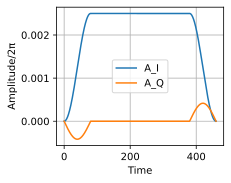

In [3]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Define parameter ranges
A_values = np.linspace(0.5e-3 * 2 * np.pi, 10e-3 * 2 * np.pi, 10)

initial_state_type = 'pc'
whatH = 'H2'
t_constant = 300
A = 5e-3 * 2 * np.pi
t_ramp = 80
"""Simulate a single point in the parameter space"""
simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
H0, H_control, initial_state, _, _ = simulation.H2()
initial_state =  qt.basis(6,1)
T = 2*t_ramp+t_constant

H_controly = 1j * np.triu(H_control.full())
H_controly = H_controly + H_controly.conj().T
H_controly = qt.Qobj(H_controly)

func = simulation.create_sinsq_ramp_function(t_ramp,T,  A/2)
freq = H0[2,2]
funcy = simulation.create_y_amplitude_function( t_ramp, T, A/2,freq)
# Create a time array spanning the entire simulation time T
t_vals = np.linspace(0, T, 500)

# Evaluate the functions at each time value
func_vals = [func(t) for t in t_vals]
funcy_vals = [funcy(t) for t in t_vals]

# Plot the two functions with amplitudes normalized by 2π
plt.figure(figsize=(3, 2.5))
plt.plot(t_vals, np.array(func_vals) / (2 * np.pi), label="A_I")
plt.plot(t_vals, np.array(funcy_vals) / (2 * np.pi), label="A_Q")
plt.xlabel("Time")
plt.ylabel("Amplitude/2π")
plt.legend()
plt.grid(True)
plt.show()



In [4]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Define parameter ranges
A_values = np.linspace(0.5e-3 * 2 * np.pi, 10e-3 * 2 * np.pi, 20)
t_ramp_values = np.linspace(20, 200,40)

initial_state_type = 'pc'
whatH = 'H2'
t_constant = 525

def simulate_single_point(A, t_ramp):
    """Simulate a single point in the parameter space"""
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()
    initial_state = np.sqrt(1/2) * qt.basis(6,0) + np.sqrt(1/2) * qt.basis(6,1) 
    T = 2*t_ramp+t_constant


    H_controly = 1j * np.triu(H_control.full())
    H_controly = H_controly + H_controly.conj().T
    H_controly = qt.Qobj(H_controly)

    func = simulation.create_sinsq_ramp_function(t_ramp,T,  A/2)
    freq = H0[2,2]
    funcy = simulation.create_y_amplitude_function( t_ramp, T, A/2,freq)
    H = [H0, [H_control, lambda t, args: func(t)], [H_controly, lambda t, args: funcy(t)]]
    tlist = np.linspace(0, T, 10000)
    
    # Use options to increase nsteps and improve integration stability
    opts = {'nsteps': int(2*t_ramp+t_constant*1), 'atol': 1e-10, 'rtol': 1e-8}
    result = qt.sesolve(H, initial_state, tlist, options=opts)
    
    # Find the indices we need to compute
    early_idx = np.where(tlist > t_ramp)[0][0] if len(np.where(tlist > t_ramp)[0]) > 0 else -1
    final_idx = len(tlist) - 1
    
    # Only compute fidelities for the two time points we need
    fidelities = []
    for idx in [early_idx, final_idx]:
        if idx >= 0:
            state_t = result.states[idx]
            t = tlist[idx]
            H_rot = H0 + func(t)*H_control
            evals, U = np.linalg.eigh(H_rot.full())
            evals, U = sort_eigenpairs(evals, U)
            
            # Compute fidelity directly without creating Qobj
            ground_overlap = np.abs(np.vdot(U[:,0], state_t.full().flatten()))**2
            excited_overlap = np.abs(np.vdot(U[:,1], state_t.full().flatten()))**2
            fidelity = ground_overlap + excited_overlap
            fidelities.append(fidelity)
        else:
            fidelities.append(0.0)
    
    return fidelities[0], fidelities[1]  # Return early and final fidelity

# Create parameter grid
A_grid, t_ramp_grid = np.meshgrid(A_values, t_ramp_values)
param_pairs = [(A_grid[i,j], t_ramp_grid[i,j]) for i in range(A_grid.shape[0]) for j in range(A_grid.shape[1])]

# Parallelize the computation
print(f"Running {len(param_pairs)} simulations...")
results = Parallel(n_jobs=-1)(delayed(simulate_single_point)(A, t_ramp) for A, t_ramp in param_pairs)

# Extract the two returned values
early_fidelities = [result[0] for result in results]
final_fidelities = [result[1] for result in results]



Running 800 simulations...


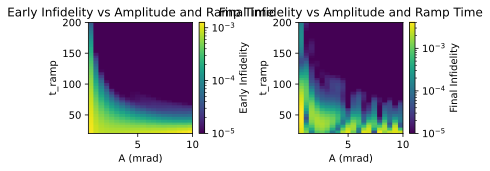

In [5]:
# Reshape results back to 2D grid
early_fidelity_grid = np.array(early_fidelities).reshape(A_grid.shape)
final_fidelity_grid = np.array(final_fidelities).reshape(A_grid.shape)

# Calculate infidelities (1 - fidelity)
early_infidelity_grid = 1 - early_fidelity_grid
final_infidelity_grid = 1 - final_fidelity_grid

from matplotlib.colors import LogNorm

# Create 2D plots for both early and final infidelities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5))

# Early infidelity plot
im1 = ax1.imshow(early_infidelity_grid, extent=[A_values[0]/(2*np.pi)*1e3, A_values[-1]/(2*np.pi)*1e3, 
                                         t_ramp_values[0], t_ramp_values[-1]], 
                aspect='auto', origin='lower' , cmap='viridis', norm=LogNorm(vmin=1e-5))
plt.colorbar(im1, ax=ax1, label='Early Infidelity')
ax1.set_xlabel('A (mrad)')
ax1.set_ylabel('t_ramp') 
ax1.set_title('Early Infidelity vs Amplitude and Ramp Time')

# Final infidelity plot
im2 = ax2.imshow(final_infidelity_grid, extent=[A_values[0]/(2*np.pi)*1e3, A_values[-1]/(2*np.pi)*1e3, 
                                         t_ramp_values[0], t_ramp_values[-1]], 
                aspect='auto', origin='lower', cmap='viridis', norm=LogNorm(vmin=1e-5))
plt.colorbar(im2, ax=ax2, label='Final Infidelity')
ax2.set_xlabel('A (mrad)')
ax2.set_ylabel('t_ramp') 
ax2.set_title('Final Infidelity vs Amplitude and Ramp Time')

plt.tight_layout()
plt.show()


In [6]:
def white_noise(A):
    """
    Measure T1 and T2 times for a given amplitude A.
    
    Parameters:
    A : float
        Amplitude parameter
        
    Returns:
    tuple : (T1_fitted, T2_fit)
        Fitted T1 and T2 times
    """
    # Perform quantum simulation with noise trajectories
    from qutip import sesolve, basis, sigmaz, sigmax
    from joblib import Parallel, delayed
    import matplotlib.pyplot as plt

    gamma = 1/(2e4)

    options = {'rtol': 1e-12, 'atol': 1e-12}
    # T1 measurement (01 -> 00 decay)
    initial_state_type = '01'
    whatH = 'H2'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()
    P00, P01, P10, P11 = M

    t_list = np.linspace(0, 10000, 20000)
    H = [H0 + A/2*H_control]
    L = np.sqrt(gamma) * qt.Qobj(simulation.s)
    c_ops = [L]

    result = qt.mesolve(H, initial_state, t_list, c_ops, options=options)

    avg_values_P00 = [qt.expect(P00, state) for state in result.states]

    def fit1(t, T1):
        return 1 - np.exp(-t / T1)

    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(fit1, t_list, avg_values_P00)
    T1_fitted = popt[0]

    # T2 measurement (superposition state decay)
    initial_state_type = 'pc'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()

    t_list = np.linspace(0, 10000, 20000)

    result = qt.mesolve(H, initial_state, t_list, c_ops, options=options)

    avg_values_Pxc = [qt.expect(M, state) for state in result.states]
    def T2fit(t, T2):
        return np.exp(-t / T2) * np.cos(simulation.omega_c * t)

    popt, pcov = curve_fit(T2fit, t_list, avg_values_Pxc, p0=[1e6])
    T2_fit = popt[0]
    dephasing_rate1 = 1/T2_fit - 1/T1_fitted/2
    evals, U = np.linalg.eigh((H0 + A/2*H_control).full())
    evals, U = sort_eigenpairs(evals, U)
    Ud = U.conj().T
    dephasing_rate2 = (np.abs((Ud@simulation.s@U))[2,0]**2/2 + np.abs((Ud@simulation.s@U))[3,1]**2/2 + (np.abs((Ud@simulation.s@U))[1,1] - np.abs((Ud@simulation.s@U))[0,0])**2/2)*gamma
    dephasing_rate3 = gamma*(((2*A/(0.1*2*np.pi))**(2/3)/4)**2 + (0.01*(0.1*2*np.pi/(2*A))**(1/3))**2/2)
    return dephasing_rate1, dephasing_rate2, dephasing_rate3


In [7]:
import os

# Set environment variables to disable threading
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

A_values = np.linspace(0.1e-3, 5e-3, 20) * 2 * np.pi
dephasing_rates1 = []
dephasing_rates2 = []
dephasing_rates3 = []

from joblib import Parallel, delayed

results = Parallel(n_jobs=-1)(delayed(white_noise)(A) for A in A_values)

for rate1, rate2, rate3 in results:
    dephasing_rates1.append(rate1)
    dephasing_rates2.append(rate2)
    dephasing_rates3.append(rate3)

dephasing_rates1 = np.array(dephasing_rates1)
dephasing_rates2 = np.array(dephasing_rates2)
dephasing_rates3 = np.array(dephasing_rates3)


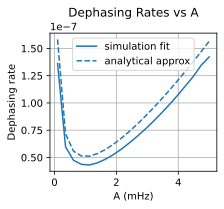

In [34]:
plt.figure(figsize=(3, 2.5))
plt.plot(A_values/(2*np.pi)*1e3, dephasing_rates1, '-', label='simulation fit', color='C0')
# plt.plot(A_values/(2*np.pi)*1e3, dephasing_rates2, 's-', label='analytical exact')
plt.plot(A_values/(2*np.pi)*1e3, dephasing_rates3, '--', label='analytical approx', color='C0')
plt.xlabel('A (mHz)')
plt.ylabel('Dephasing rate')
plt.title('Dephasing Rates vs A')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def simulate_colored_noise_dephasing(A, S0, t_max, num_realizations, initial_state_type):
    """
    Simulate dephasing due to colored noise for given parameters.
    
    Parameters:
    -----------
    A : float
        Coupling strength
    S0 : float
        Noise amplitude
    t_max : int
        Maximum time in ns
    num_realizations : int
        Number of noise realizations
    
    Returns:
    --------
    tuple
        (time_points, result) where result is array of shape (num_realizations, N)
    """
    # T1 measurement (01 -> 00 decay)
    whatH = 'H2'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()
    if initial_state_type == '00':
        P = M
    elif initial_state_type == '01':
        _, _,_ ,P = M
    # Initialize arrays to store results
    N = t_max
    time_points = np.linspace(0, t_max, N)

    sample_rate = 1        # per ns
    tnoise_max = int(1e5)             # number of samples
    relative_PSD_strength = S0**2
    ifwhite = False               # True for white noise, False for 1/f noise
    
    gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
    trajs = gn.generate_colored_noise()

    def simulate_trajectory(i):
        # Create Hamiltonian with increased nsteps for better integration
        traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
        H = [H0 + A/2*H_control, [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
        
        # Use options to increase nsteps and improve integration stability
        opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
        result = qt.sesolve(H, initial_state, time_points, options=opts)
        avg_values = np.zeros(len(time_points))
        
        for j, t in enumerate(time_points):
            state_t = result.states[j]
            avg_values[j] = qt.expect(P, state_t) 
        return avg_values

    result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

    # Convert to numpy array for easier analysis
    result = np.array(result)
    
    return time_points, simulation, result, S0




In [9]:
# Example usage with specific parameters
initial_state_type = '00'
A_values = [1e-3 * 2 * np.pi, 3e-3 * 2 * np.pi, 5e-3 * 2 * np.pi]
S0_values = np.logspace(-6, -5, 5)  # 10 points from 1e-6 to 1e-5
t_max = 10000
num_realizations = 100

# Store results for plotting
T2_results = {}

# Loop over A values
for A in A_values:
    T2_fit_list = []
    T2_exact_list = []
    T2_app_list = []
    
    # Loop over S0 values
    for S0 in S0_values:
        time_points, simulation, result, S0_used = simulate_colored_noise_dephasing(A, S0, t_max, num_realizations, initial_state_type)
        avg_values = np.mean(result, axis=0)
        T2_fit, T2_exact, T2_app = simulation.analyze_and_fit_decay(simulation, time_points, avg_values, S0, ifplot=False)
        
        T2_fit_list.append(T2_fit)
        T2_exact_list.append(T2_exact)
        T2_app_list.append(T2_app)
    
    T2_results[A] = {
        'T2_fit': T2_fit_list,
        'T2_exact': T2_exact_list,
        'T2_app': T2_app_list
    }


For A = 5.0 mHz, slope = 2.07


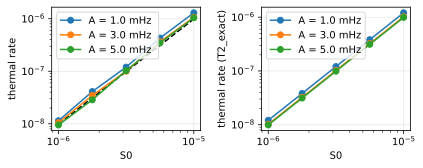

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))

# For the first plot, plot a single T2_app dashed line as the background (using the first A value) with no label
A_app = A_values[0]
axes[0].loglog(S0_values, 1/np.abs(np.array(T2_results[A_app]['T2_app'])),
               '--', color='black')

# Overlay the T2_fit results in black; only the one for A = 5 mHz will be labeled
for A in A_values:
    if A/(2*np.pi)*1e3 == 5.0:  # For A = 5 mHz, compute and print the fit slope, and label it
        log_x = np.log10(S0_values)
        log_y = np.log10(1/np.array(T2_results[A]['T2_fit']))
        slope, intercept = np.polyfit(log_x, log_y, 1)
        axes[0].loglog(S0_values, 1/np.array(T2_results[A]['T2_fit']),
                       'o-', label=f'A = {A/(2*np.pi)*1e3:.1f} mHz ')
        print(f'For A = {A/(2*np.pi)*1e3:.1f} mHz, slope = {slope:.2f}')
    else:
        axes[0].loglog(S0_values, 1/np.array(T2_results[A]['T2_fit']),
                       'o-', label=f'A = {A/(2*np.pi)*1e3:.1f} mHz ')

axes[0].set_xlabel('S0')
axes[0].set_ylabel('thermal rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Second plot: show T2_exact results as before
for A in A_values:
    axes[1].loglog(S0_values, 1/np.abs(np.array(T2_results[A]['T2_exact'])),
                   'o-', label=f'A = {A/(2*np.pi)*1e3:.1f} mHz')

axes[1].set_xlabel('S0')
axes[1].set_ylabel('thermal rate (T2_exact)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
def measure_T1_and_T2_star(A, S0, t_max, num_realizations):
    """
    Measure T1 and T2* for given parameters and return pure dephasing rate.
    
    Parameters:
    A: Drive amplitude
    S0: Noise strength
    t_max: Maximum simulation time
    num_realizations: Number of noise realizations
    
    Returns:
    Pure dephasing rate (1/T2* - 1/(2*T1))
    """
    sample_rate = 1        # per ns
    tnoise_max = int(1e5)             # number of samples
    relative_PSD_strength = S0**2
    ifwhite = False               # True for white noise, False for 1/f noise
    gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
    trajs = gn.generate_colored_noise()

    # Define parameter ranges
    gamma = 1/(2e4)
    
    # T1 measurement (01 -> 00 decay)
    initial_state_type = '01'
    whatH = 'H2'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()
    P00, P01, P10, P11 = M

    L = np.sqrt(gamma) * qt.Qobj(simulation.s)
    c_ops = [L]

    time_points = np.linspace(0, 1000, 1000)
    def simulate_trajectory(i):
        traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
        H = [H0 + A/2*H_control, [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
        opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
        result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)
        avg_values = np.zeros(len(time_points))
        
        for j, t in enumerate(time_points):
            state_t = result.states[j]
            avg_values[j] = qt.expect(P00, state_t) 
        return avg_values

    result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))
    # Convert to numpy array for easier analysis
    result = np.array(result)
    avg_values  =   np.mean(result, axis=0)    
    def fit1(t, T1):
        return 1 - np.exp(-t / T1)

    popt, pcov = curve_fit(fit1, time_points, avg_values)
    T1_fitted = popt[0]

    # T2* measurement (pc -> pc decay)
    initial_state_type = 'pc'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()

    time_points = np.linspace(0, t_max, 20000)
    def simulate_trajectory(i):
        traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
        H = [H0 + A/2*H_control, [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
        opts = {'nsteps': t_max*1, 'atol': 1e-12, 'rtol': 1e-12}
        result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)
        avg_values = np.zeros(len(time_points))
        
        for j, t in enumerate(time_points):
            state_t = result.states[j]
            avg_values[j] = qt.expect(M, state_t) 
        return avg_values

    result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

    # Convert to numpy array for easier analysis
    result = np.array(result)
    avg_value = np.mean(result, axis=0)
    T2,_,_ = simulation.analyze_and_fit_decay(simulation, time_points, avg_value, S0, ifplot=False)
    
    return (1/T2 - 1/T1_fitted/2)

# Parameter sweep
A_values = [1e-3 * 2 * np.pi, 3e-3 * 2 * np.pi, 5e-3 * 2 * np.pi]
S0_values = np.logspace(-6, -5, 5)  # 10 points from 1e-6 to 1e-5
t_max = 10000
num_realizations = 100

# Store results
results = {}

# Sweep over A values
for A in A_values:
    rates = []
    for S0 in S0_values:
        print(f"Computing for A = {A/(2*np.pi):.3e}, S0 = {S0:.3e}")
        rate = measure_T1_and_T2_star(A, S0, t_max, num_realizations)
        rates.append(rate)
    results[A] = rates

Computing for A = 1.000e-03, S0 = 1.000e-06
Computing for A = 1.000e-03, S0 = 1.778e-06
Computing for A = 1.000e-03, S0 = 3.162e-06
Computing for A = 1.000e-03, S0 = 5.623e-06
Computing for A = 1.000e-03, S0 = 1.000e-05
Computing for A = 3.000e-03, S0 = 1.000e-06
Computing for A = 3.000e-03, S0 = 1.778e-06
Computing for A = 3.000e-03, S0 = 3.162e-06
Computing for A = 3.000e-03, S0 = 5.623e-06
Computing for A = 3.000e-03, S0 = 1.000e-05
Computing for A = 5.000e-03, S0 = 1.000e-06
Computing for A = 5.000e-03, S0 = 1.778e-06
Computing for A = 5.000e-03, S0 = 3.162e-06
Computing for A = 5.000e-03, S0 = 5.623e-06
Computing for A = 5.000e-03, S0 = 1.000e-05


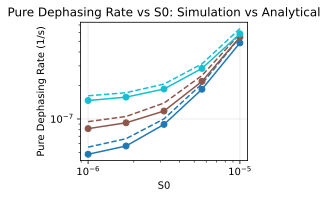

In [12]:
# Compute analytical rates for all A and S0 values
gamma = 1/(2e4)
analytical_results = {}

for A in A_values:
    analytical_rates = []
    for S0 in S0_values:
        S0P = S0*(simulation.sc.omega_s_per - simulation.sc.omega_s)/1e-6
        analytical_rate = gamma*(((2*A/(0.1*2*np.pi))**(2/3)/4)**2 + (0.01*(0.1*2*np.pi/(2*A))**(1/3))**2/2) + (S0P**2/0.1/4)
        analytical_rates.append(analytical_rate)
    analytical_results[A] = analytical_rates
# Plot comparison between simulation and analytical results
plt.figure(figsize=(3, 2.5))
for A in A_values:
    colors = plt.cm.tab10(np.linspace(0, 1, len(A_values)))
    color = colors[list(A_values).index(A)]
    plt.loglog(S0_values, analytical_results[A], '--', color=color, label=f'Ana A = {A/(2*np.pi):.1e}')
    plt.loglog(S0_values, results[A], 'o-', color=color, label=f'Sim A = {A/(2*np.pi):.1e}')

plt.xlabel('S0')
plt.ylabel('Pure Dephasing Rate (1/s)')
plt.title('Pure Dephasing Rate vs S0: Simulation vs Analytical')

plt.grid(True, alpha=0.3)
plt.show()


In [13]:
sample_rate = 1e-3        # per ns
S0 = 1e-5
tnoise_max = int(1e8)             # number of samples
relative_PSD_strength = S0**2
ifwhite = False               # True for white noise, False for 1/f noise
num_realizations = 100
gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
trajs = gn.generate_colored_noise()

# Define parameter ranges
gamma = 1/(2e4)

# T1 measurement (01 -> 00 decay)
initial_state_type = 'pc'
whatH = 'H2'
A = 0
simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
H0, H_control, initial_state, M, noise = simulation.H2()
L = np.sqrt(gamma) * qt.Qobj(simulation.s)
c_ops = [L]
t_max = 75000
time_points = np.linspace(0, t_max, 20000)
def simulate_trajectory(i):
    traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
    H = [H0 + A/2*H_control, [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
    opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
    result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)
    avg_values = np.zeros(len(time_points))
    
    for j, t in enumerate(time_points):
        state_t = result.states[j]
        avg_values[j] = qt.expect(M, state_t) 
    return avg_values

result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

In [14]:
avg_values0 = np.mean(result, axis=0)

In [ ]:
sample_rate = 1        # per ns
tnoise_max = int(1e5)             # number of samples
relative_PSD_strength = S0**2
ifwhite = False               # True for white noise, False for 1/f noise
S0 = 1e-5
relative_PSD_strength = S0**2
num_realizations = 100
gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
trajs = gn.generate_colored_noise()

# Define parameter ranges
gamma = 1/2e4

A = 5e-3 * 2 * np.pi
simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
H0, H_control, _, _, noise = simulation.H2()
initial_state = np.sqrt(1/2) * qt.basis(6,0) + np.sqrt(1/2) * qt.basis(6,1) 
t_ramp = 300
t_constant = t_max - 2*t_ramp
func = simulation.gaussian_ramp(t_ramp, t_constant, t_ramp, A/2)
func = simulation.create_sinsq_ramp_function(t_ramp,T,  A/2)

freq = H0[2,2]
funcy = simulation.create_y_amplitude_function( t_ramp, T, A/2,freq)
H = [H0, [H_control, lambda t, args: func(t)], [H_controly, lambda t, args: funcy(t)]]

tlist = np.linspace(0, 2*t_ramp+t_constant, 10000)

L = np.sqrt(gamma) * qt.Qobj(simulation.s)
c_ops = [L]
time_points = np.linspace(0, t_max, 20000)
def simulate_trajectory(i):
    traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
    H = [ H0, [H_control, lambda t, args: func(t)], [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
    opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
    result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)
    avg_values = np.zeros(len(time_points))

    H_rot = H0 + func(2000)*H_control
    evals, U = np.linalg.eigh(H_rot.full())
    evals, U = sort_eigenpairs(evals, U)
    Ud = U.conj().T
    for j, t in enumerate(time_points):
        state_t = result.states[j]
        t = time_points[j]
        sigmax = np.kron(np.eye(3), np.array([[0, 1], [1, 0]]))
        sigmax = U@sigmax@Ud
        sigmax = qt.Qobj(sigmax)
        avg_values[j] = np.real(qt.expect(sigmax, state_t)) 
    return avg_values

result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

AttributeError: 'Simulation' object has no attribute 'gaussian_ramp'

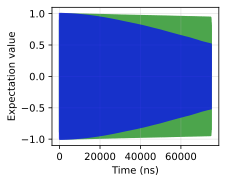

In [ ]:
# Fit envelope to the averaged data
from scipy.optimize import curve_fit

def exp_decay_fixed_offset(t, T):
    return np.exp(-t**2/ T**2) * np.cos(simulation.omega_c * t)

def envolope(t, T):
    return np.exp(-t**2  / T**2) 

def envolope2(t, T):
    return np.exp(-t / T) 

# Fit the envelope
popt, pcov = curve_fit(exp_decay_fixed_offset, time_points, avg_values0, p0=[1e5])
T_fit = popt[0]

# Get the second dataset
avg_values = np.mean(np.array(result),axis = 0)

# Plot both datasets in the same figure
plt.figure(figsize=(3, 2.5))

# Plot first curve (on top if overlapping)
plt.plot(time_points, avg_values0, 'b-', alpha=0.7, zorder=2)
# plt.plot(time_points, envolope(time_points, 92000), 'r--',  linewidth=2, zorder=2)

# Plot second curve (below if overlapping)
plt.plot(time_points, avg_values, 'g-', alpha=0.7, zorder=1)
# plt.plot(time_points, envolope2(time_points, 1165172), 'c--', linewidth=2, zorder=1)

plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.grid(True, alpha=0.3)
# plt.ylim(0.5, 1.0)
# plt.ylim(0.98,1)
plt.show()

In [77]:
A = 5e-3 * 2 * np.pi
simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
H0, H_control, initial_state, M, noise = simulation.H2()
L = np.sqrt(gamma) * qt.Qobj(simulation.s)
c_ops = [L]
time_points = np.linspace(0, t_max, 20000)
def simulate_trajectory(i):
    traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
    H = [H0 + A/2*H_control, [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
    opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
    result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)
    avg_values = np.zeros(len(time_points))
    
    for j, t in enumerate(time_points):
        state_t = result.states[j]
        avg_values[j] = qt.expect(M, state_t) 
    return avg_values

result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

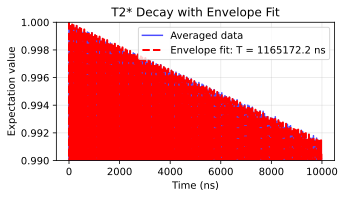

In [78]:
avg_values = np.mean(result, axis=0)
# Fit envelope to the averaged data
from scipy.optimize import curve_fit

def exp_decay_fixed_offset(t, T):
    return np.exp(-t / T) * np.cos(simulation.omega_c * t)

def envolope(t, T):
    return np.exp(-t / T) 

# Fit the envelope
popt, pcov = curve_fit(exp_decay_fixed_offset, time_points, avg_values, p0=[1e4])
T_fit = popt[0]

# Plot the data and fit
plt.figure(figsize=(5, 2.5))
plt.plot(time_points, avg_values, 'b-', label='Averaged data', alpha=0.7)
plt.plot(time_points, exp_decay_fixed_offset(time_points, T_fit), 'r--', 
         label=f'Envelope fit: T = {T_fit:.1f} ns', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('T2* Decay with Envelope Fit')
plt.ylim(0.99, 1.0)
plt.show()


In [81]:
1/T_fit - 1/2e6/2

np.float64(6.082422085826885e-07)